# ARIMA Model for stock prices

In this notebook I've built an ARIMA model for AAPL stock closing prices.

In [28]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

## Import data from Google Cloud Storage

In this section I've read ten years' worth of AAPL stock data into a Pandas dataframe. 

In [29]:
df = pd.read_csv('gs://cloud-training/ai4f/AAPL10Y.csv')

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786


## Aggregating stock closing price on weekly basis

In [30]:
df_week = df.resample('w').mean()
df_week = df_week[['close']]
df_week.head()

,close
date,
2009-06-07,20.445700
2009-06-14,20.106860
2009-06-21,19.525140
2009-06-28,19.711440
2009-07-05,20.258925


I've experimented and found that d = 2 i.e. twice difference works best

In [31]:
df_week['weekly_ret'] = df_week['close'].diff().diff()
df_week.head()

,close,weekly_ret
date,,
2009-06-07,20.445700,NaN
2009-06-14,20.106860,NaN
2009-06-21,19.525140,-0.242880
2009-06-28,19.711440,0.768020
2009-07-05,20.258925,0.361185


In [32]:
# drop null rows
df_week.dropna(inplace=True)

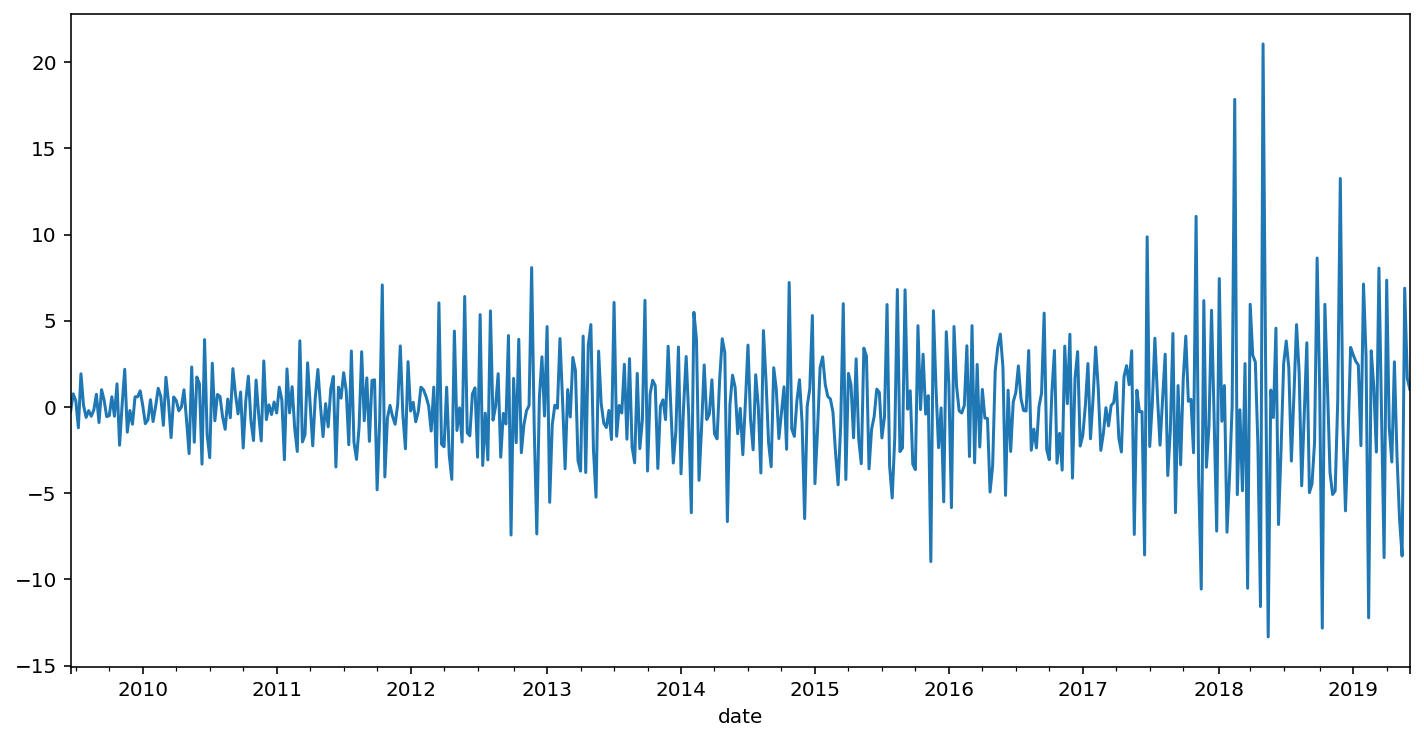

In [33]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

In [34]:
udiff = df_week.drop(['close'], axis=1)
udiff.head()

,weekly_ret
date,
2009-06-21,-0.242880
2009-06-28,0.768020
2009-07-05,0.361185
2009-07-12,-1.203250
2009-07-19,1.931485


## Test for stationarity of the udiff series

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity. 

In [35]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [36]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

## Plot for visualizing Stationarity of udiff

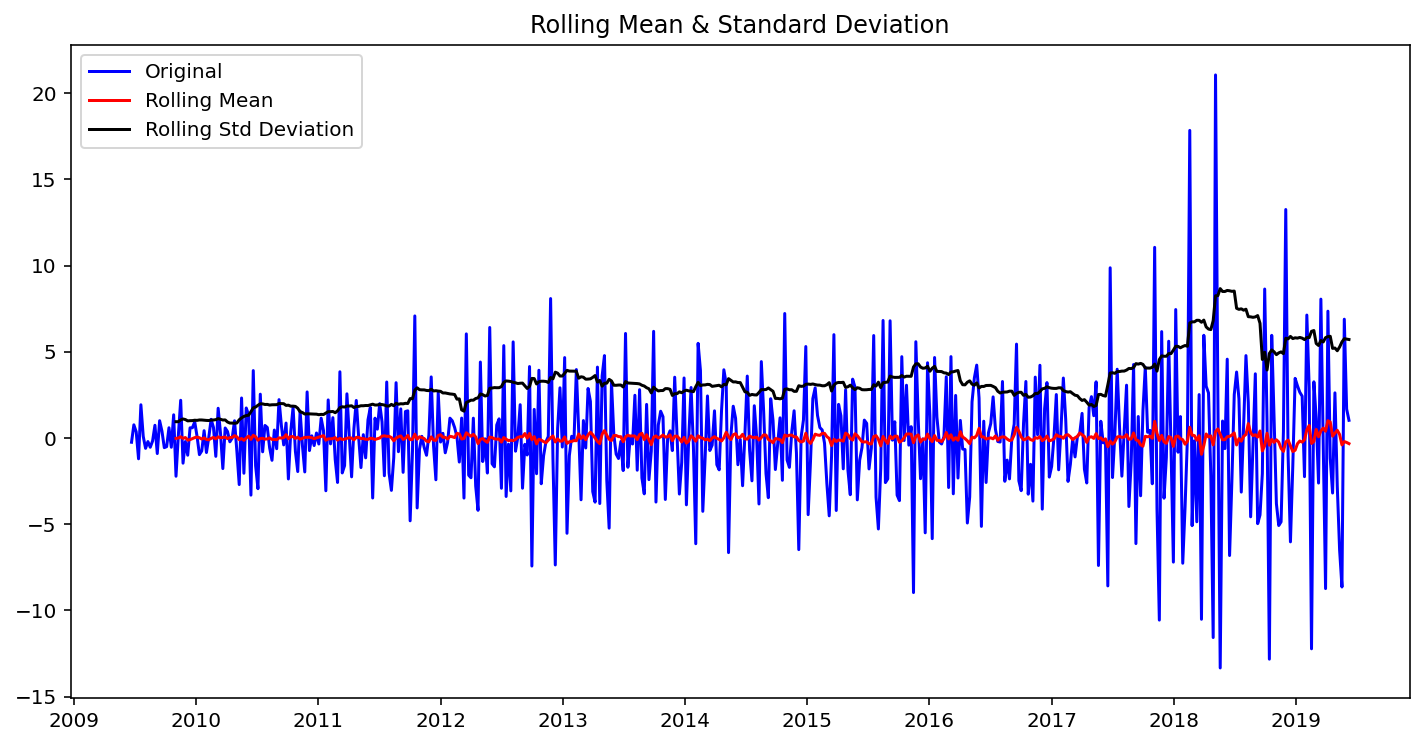

In [37]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

### We see that Rolling Mean oscillating very close to 0. Though Rolling Std seems to be a little trendy.
### Let's use Dickey-Fuller Test to determine if udiff is indeed Stationary

In [38]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -9.092905e+00
p-value                        3.781956e-15
#Lags Used                     1.900000e+01
Number of Observations Used    5.010000e+02
Critical Value (1%)           -3.443470e+00
Critical Value (5%)           -2.867326e+00
Critical Value (10%)          -2.569852e+00
dtype: float64

With a p-value < 0.05, we can reject the null hypotehsis. This data set is stationary.

## ACF and PACF Charts to determine value of p & q

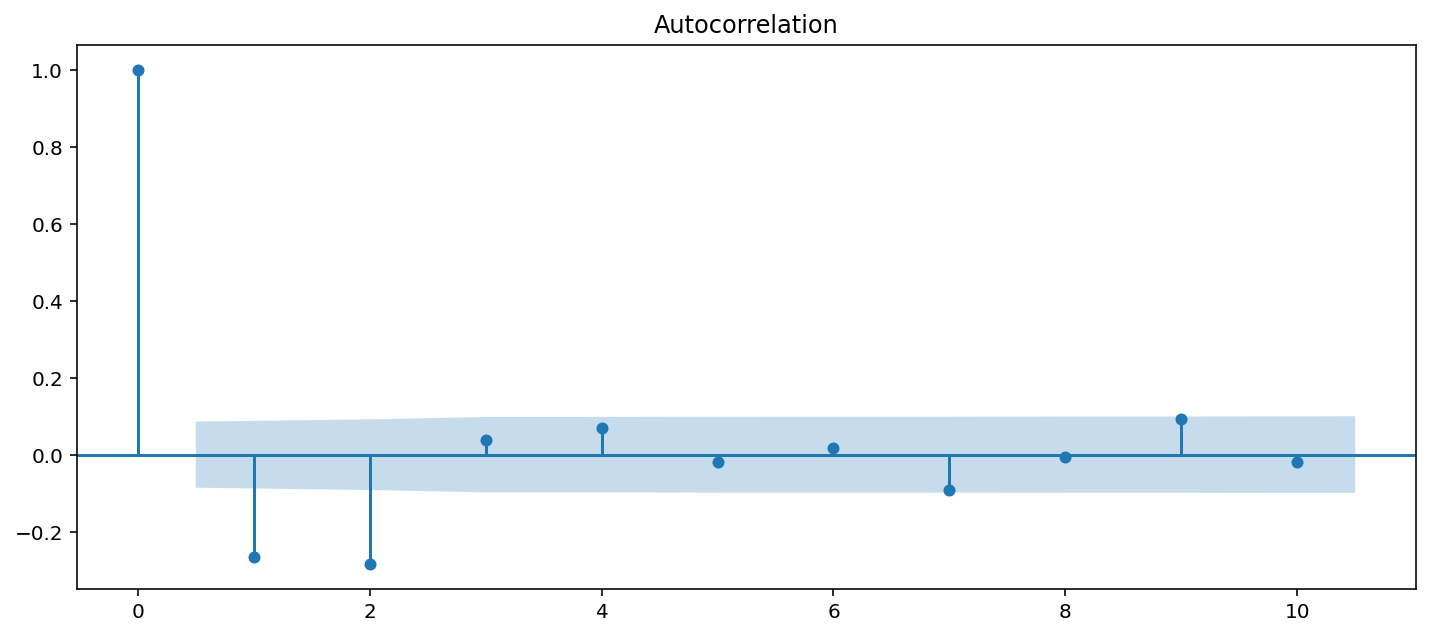

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

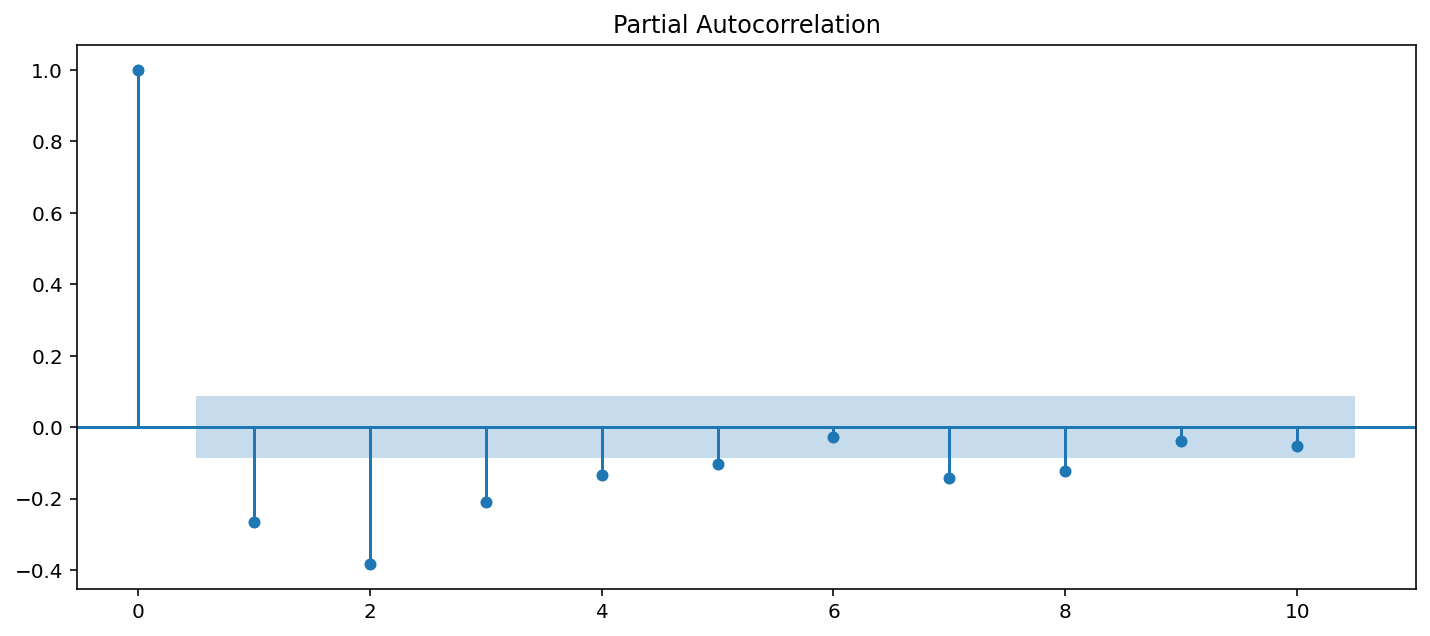

In [40]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The above chart shows that reading PACF gives us a lag "p" = 1,2 or 3 and reading ACF gives us a lag "q" of 1 or 2. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

## This is an iterative process I've found that the best fit value is p = 0 & q = 1

# Build ARIMA Model

Since we differenced the weekly closing prices, we technically only need to build an ARMA model. The data has already been integrated and is stationary. In a way using simply an ARMA model is like using an ARIMA model here with d = 2.

In [63]:
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data rather than the original data. 
ar1 = ARMA(tuple(udiff.values), (0, 1)).fit()
ar1.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  521
Model:                     ARMA(0, 1)   Log Likelihood               -1331.146
Method:                       css-mle   S.D. of innovations              3.112
Date:                Tue, 26 Jan 2021   AIC                           2668.291
Time:                        17:18:07   BIC                           2681.059
Sample:                             0   HQIC                          2673.292
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0075      0.033     -0.226      0.821      -0.073       0.058
ma.L1.y       -0.7573      0.048    -15.646      0.000      -0.852      -0.662
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.3204           +0.0000j            1.3204            0.0000
-----------------------------------------------------------------------------
"""

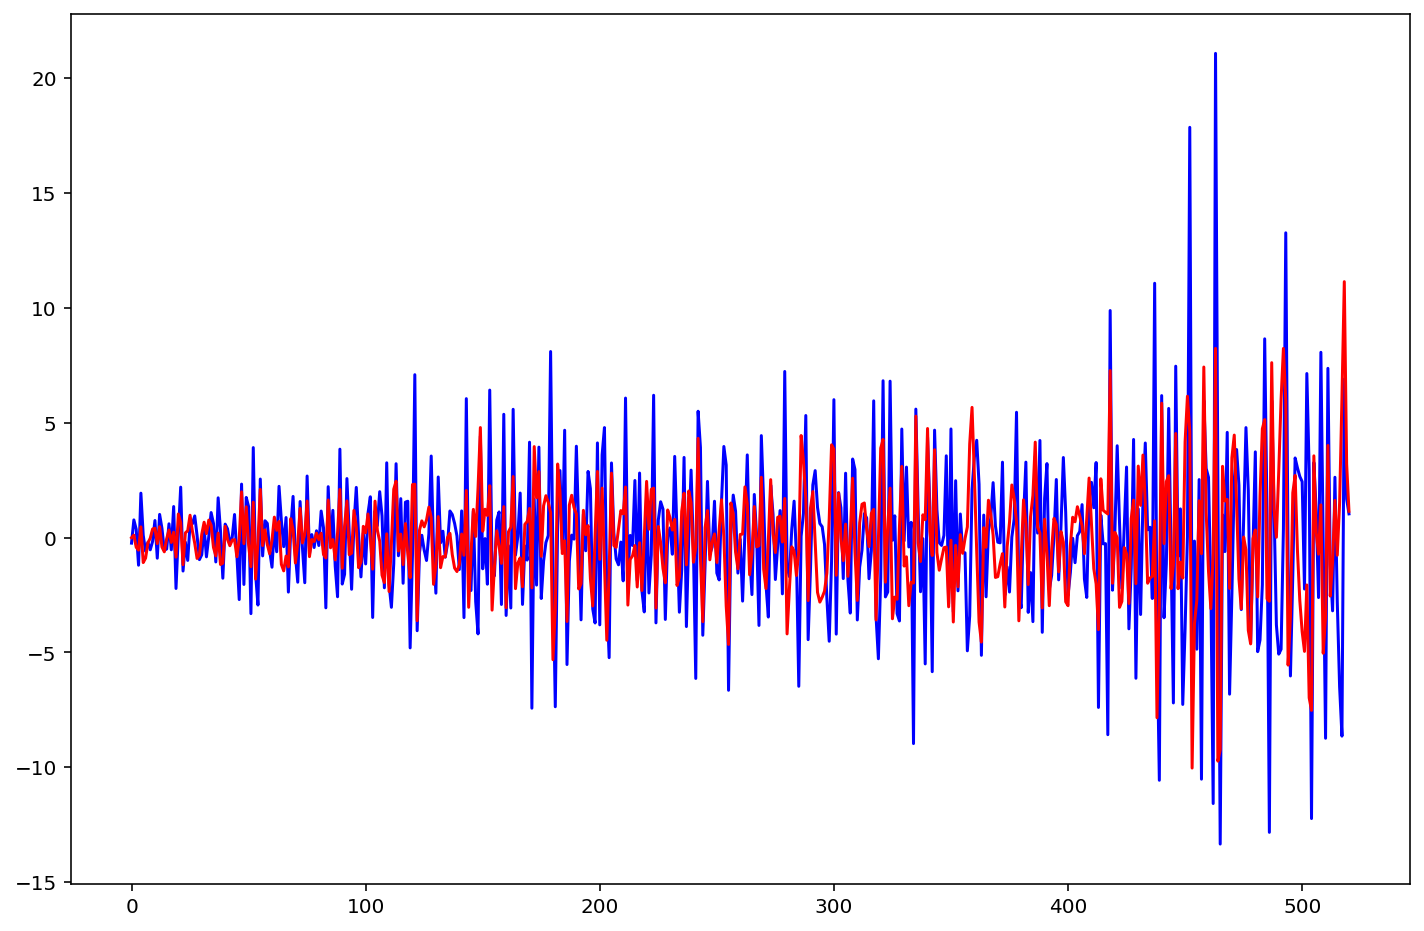

In [64]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Let's make a forecast 2 weeks ahead:

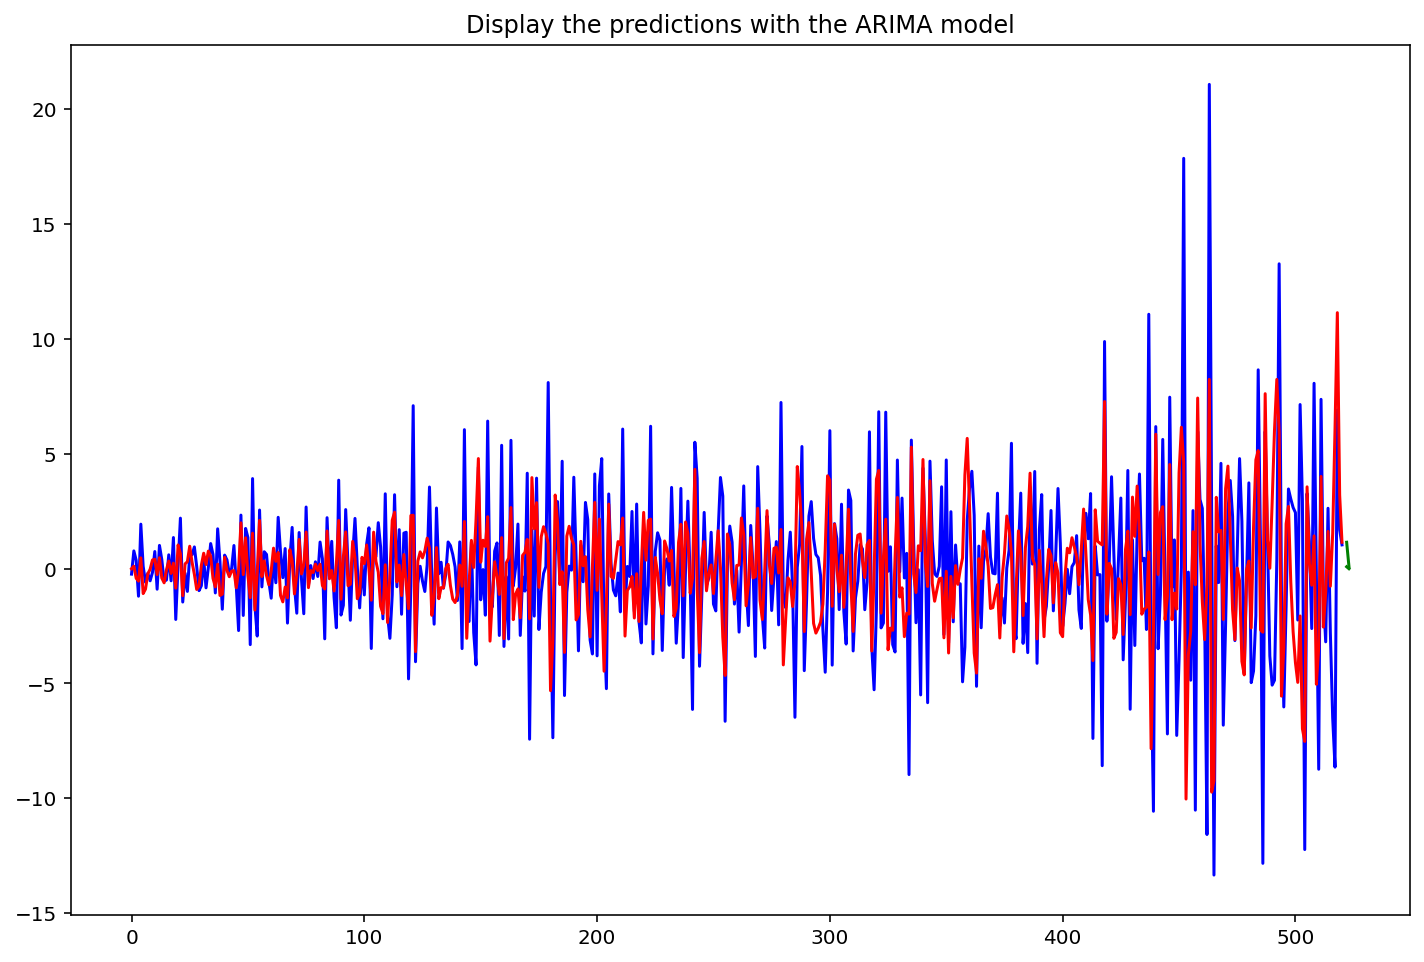

In [69]:
steps = 2

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

The forecast is not great but if you tune the hyper parameters some more, you might be able to reduce the errors.